In [335]:
import math
import os
import seaborn as sns

from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, floor
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal
from scipy.stats import rv_discrete

In [336]:
class Memory():
    
    def __init__(self):
        self.reset()
        self.all_rewards = []
    
    def reset(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        
    def push(self, s, a, lp):
        self.states.append(s)        
        self.actions.append(a)        
        self.log_probs.append(lp)
        
    def save_reward(self, r):
        self.rewards.append(r)        
        self.all_rewards.append(r)

In [337]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class AgentNet(nn.Module):
    def __init__(self, n_players, n_coins, episode_len, epsilon=0.1, n_actions=2, lr = 0.01, _gamma = 0.99):
        super(AgentNet, self).__init__()
        
        self.n_players = n_players
        self.n_coins = n_coins
        self.n_actions = n_actions # 0 non do soldi, 1 do soldi
        self.episode_len = episode_len
        
        h_size = int(n_coins)
        a_size = self.n_actions
        self.fc1 = nn.Linear(n_coins+1, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        
        self.epsilon = epsilon
        self._gamma = _gamma
        
        self.memory = Memory()
        self.opt = optim.Adam(self.parameters(), lr=lr)
        
        self.reset()
        
    def reset(self):
        self.memory.reset()

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        
        return out

    def act(self, state):
        
        state = np.array(int(state))

        state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
        state = F.one_hot(state, num_classes=self.n_coins+1).float()
        
        probs_total = self.forward(state).cpu()
        probs_total = F.softmax(probs_total, dim=1)
        
        m = Categorical(probs_total)

        #if np.random.rand() < self.epsilon:
        uniform = Categorical(probs_total)
        action = uniform.sample()
        #else:
        #    action = m.sample()
            
        log_prob = m.log_prob(action)
            
        self.memorize(state, action, log_prob)

        return action, log_prob, probs_total
    
    def memorize(self, s, a, lp):
        self.memory.push(s, a, lp)
    
    def memorize_rewards(self, r):
        self.memory.save_reward(r)
    
    def compute_G(self):
        self.G = np.zeros((self.episode_len))
        cumulative_rewards = 0
        
        for t in reversed(range(0, self.episode_len)):
            cumulative_rewards = cumulative_rewards * self._gamma + self.memory.rewards[t]
            self.G[t] = cumulative_rewards
        return self.G


In [338]:
class System():
    
    def __init__(self, n_players, n_coins, episode_len, epsilon=0.1, n_actions=2, lr=0.01, _gamma=0.99):
        
        self.n_players = n_players
        self.n_coins = n_coins
        self.n_actions = n_actions # 0 non do soldi, 1 do soldi
        self.episode_len = episode_len
        self.lr = lr
        
        self.agents = {k: AgentNet(n_players, n_coins, episode_len, epsilon, n_actions, lr) for k in range(self.n_players)}

    def reset(self):
        for _, ag in self.agents.items(): ag.reset()
            
    def act(self, coins):
        actions = np.zeros(self.n_players)
        log_probs = np.zeros(self.n_players)
        
        for i, agent in self.agents.items():
            a, log_prob, _ = agent.act(coins[i])
            actions[i] = a.detach().numpy()[0]
            log_probs[i] = log_prob
            
        return actions, log_probs
    
    def memorize_rewards(self, rews):
        for idx, ag in self.agents.items(): ag.memorize_rewards(rews[idx])
            
    def reinforce(self):
        self.losses = []
        for agent_idx, agent in self.agents.items():
            
            agent.compute_G()
            #print("ag.G=",agent.G)
            loss = 0
            for G, log_prob in zip(agent.G, agent.memory.log_probs):
                loss -= log_prob*G
            #print("loss=", loss)
            
            self.losses.append(loss.detach().numpy()[0])
            
            agent.opt.zero_grad()
            loss.backward()
            agent.opt.step()
        
    
    #def history(self, coins, actions, log_probs, rewards):
    #    for _, ag in self.agents.items(): ag.reset()
            

In [339]:
class Environment:

    def __init__(self, n_players, n_total_coins, episode_len, threshold = 0., multiplier = 1.):
        self.n_players = n_players
        self.n_total_coins = n_total_coins
        self.state = np.zeros((self.n_players,1))
        self.threshold = threshold
        self.multiplier = multiplier
        self.episode_len = episode_len
        self.rews_dict = {k: [] for k in range(self.n_players)}

    def reset(self):
        self.state = np.zeros(self.n_players)
        self.rews_dict = {k: [] for k in range(self.n_players)}
        
    def equal_division(self):
        self.coins = [int(self.n_total_coins/self.n_players) for i in range(self.n_players)]
        return self.coins
    
    def update_rews_dict(self, rew, t):
        for i in range(self.n_players):
            self.rews_dict[i].append(rew[i])
            
    def sample(self):
        left_coins = self.n_total_coins
        self.coins = []
        
        for i in range(self.n_players):
            if (i == self.n_players - 1):
                self.coins.append(left_coins)
            else:
                val = int(np.random.choice(left_coins-1, 1))
                self.coins.append(val)
                left_coins = lect_coins - val 
                
        return self.coins

    def step(self, coins, actions):
        rewards = np.zeros(self.n_players)
        
        if (np.sum(actions)) < self.threshold:
            return rewards
        
        amount = np.sum([coins[i] for i in range(self.n_players) if actions[i] == 1])
            
        for i in range(self.n_players):
            if (actions[i] == 1.):
                rewards[i] = amount/self.n_players*self.multiplier
            else:
                rewards[i] = amount/self.n_players*self.multiplier + coins[i]
                
            # trick to avoid log(0) 
            if rewards[i] <= 0:
                rewards[i] = 1e-6

        return rewards

# Multi-Step Reinforce

In [340]:
def reinforce_horizon_players(n_players=5, n_coins=10, n_episodes=1, episode_len=10, epsilon=0.1, \
                              threshold=0., multiplier=1., gamma=0.9):
    
    torch.autograd.set_detect_anomaly(True)
    
    df = pd.DataFrame(columns=['episode', 't', 'loss0', 'loss1', 'loss2'])
                      
    env = Environment(n_players, n_coins, episode_len, threshold, multiplier)
    system = System(n_players, n_coins, episode_len, epsilon)
    
    history_rewards = {k: [] for k in range(n_players)}

    line = 0
    
    for e in range(n_episodes):
        
        env.reset()
        system.reset()
        
        if ( e == int(n_episodes/2) ):
            for agent_idx, ag in system.agents.items():
                ag.epsilon = 0.1
        if (e == int(n_episodes - 50)):
            ag.epsilon = 0.0001
                
        for t in range(0, episode_len):
            
            coins = env.equal_division()
            
            act, log_prob = system.act(coins)
            
            rews = env.step(coins, act)
            env.update_rews_dict(rews, t)
            
            system.memorize_rewards(rews)
            
        #print("act=", act)
        #print("rews=", rews)
        
        system.reinforce()
                  
        df.loc[line] = [e, t] + system.losses
        line += 1

        
        if (e%100 == 0):
            print("==> Episode=", e)
            print(system.losses)
            #print("epsilon=", system.agents[0].epsilon)
            #print("act=", act)
            #print("rews=", rews)
            
    return df, history_rewards, system.agents

In [341]:
n_episodes = 1000
episode_len = 5

n_players = 3
n_coins = 9

threshold = 0.
multiplier = 2.
epsilon = 0.2

df, hr, agents = reinforce_horizon_players(n_players=n_players, n_coins=n_coins, n_episodes=n_episodes, \
                                           episode_len=episode_len, epsilon = epsilon, threshold = threshold, \
                                           multiplier=multiplier)

==> Episode= 0
[49.689545, 25.762379, 50.561424]
epsilon= 0.2
==> Episode= 100
[58.900185, 31.531456, 47.608307]
epsilon= 0.2
==> Episode= 200
[49.00356, 40.559155, 49.423153]
epsilon= 0.2
==> Episode= 300
[2.2066185, 24.499119, 0.692969]
epsilon= 0.2
==> Episode= 400
[1.0876964, 28.760735, 0.414439]
epsilon= 0.2
==> Episode= 500
[0.1887061, 1.1523985, 0.42240405]
epsilon= 0.1
==> Episode= 600
[0.09385895, 0.55384487, 0.24119513]
epsilon= 0.1
==> Episode= 700
[0.27580598, 0.9791678, 0.11104397]
epsilon= 0.1
==> Episode= 800
[0.10699529, 7.915404, 0.21404001]
epsilon= 0.1
==> Episode= 900
[0.11262272, 0.38082296, 0.07908536]
epsilon= 0.1


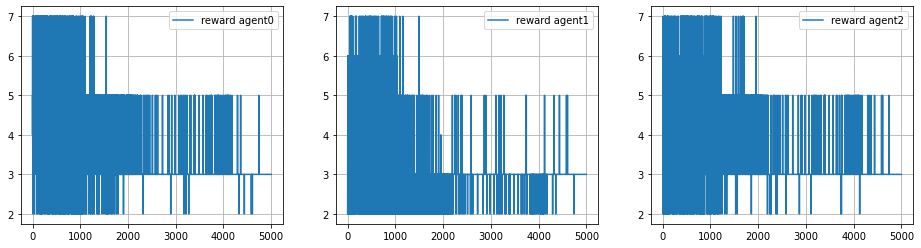

In [342]:
figure, ax = plt.subplots(1, n_players, figsize=(16, 4))

for i in range(n_players):
    ax[i].plot(np.linspace(0, n_episodes*episode_len, n_episodes*episode_len), agents[i].memory.all_rewards, label='reward agent'+str(i))
    ax[i].legend()
    ax[i].grid()
plt.show()

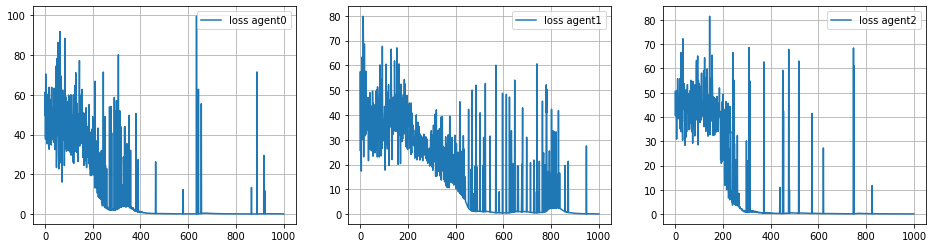

In [343]:
figure, ax = plt.subplots(1, n_players, figsize=(16, 4))

for i in range(n_players):
    ax[i].plot(np.linspace(0, n_episodes, n_episodes), df['loss'+str(i)], label='loss agent'+str(i))
    ax[i].legend()
    ax[i].grid()
plt.show()

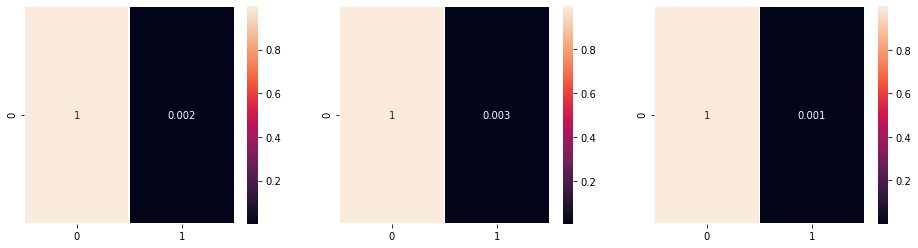

In [344]:
n_coins = 3

figure, ax = plt.subplots(1, 3, figsize=(16, 4))

for i in range(n_players):
    a, log_prob, probs = agents[i].act(np.array(n_coins))
    probbs = probs.detach().numpy()
    
    sns.heatmap(probbs, annot=True, linewidth=.5,ax=ax[i])
plt.show()